# Capstone 2 Modeling (day)

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tbats import BATS, TBATS
%matplotlib inline

In [2]:
# load the csv files in data/processed folder
df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df24.csv', index_col='Date')
df6 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2016.csv', index_col='Date')
df7 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\df2017.csv', index_col='Date')
# change indexes to time series
df2.index = pd.to_datetime(df2.index)
df6.index = pd.to_datetime(df6.index)
df7.index = pd.to_datetime(df7.index)
# set the index frequency
df2.index.freq="D"
df6.index.freq="D"
df7.index.freq="D"
df2.head()

11:00:00  12:00:00  13:00:00  14:00:00  15:00:00  16:00:00  \
Date                                                                     
2016-01-04     16.39     36.27     78.68     51.44     57.70    148.93   
2016-01-05     22.45     27.75      7.25     30.64    100.67    149.72   
2016-01-06     33.59     41.48    111.56     92.00     94.83     94.27   
2016-01-07      8.40     23.30     54.49     42.28    116.13    101.65   
2016-01-08     27.25     86.00     48.34     65.21    186.20    158.67   

            17:00:00  18:00:00  19:00:00  20:00:00  21:00:00  22:00:00  \
Date                                                                     
2016-01-04     74.55     50.34     56.02     79.35     58.34     31.68   
2016-01-05     43.14     68.53     93.65     75.90     27.45     31.70   
2016-01-06     45.26     70.35     57.22     52.53     46.87     49.12   
2016-01-07     52.04     47.96    128.00     77.01     91.02     75.42   
2016-01-08     93.76    117.30    143.23    105.70    182.96     89.71   

            23:00:00    Daily  
Date                           
2016-01-04      0.00   739.69  
2016-01-05      0.00   678.85  
2016-01-06      0.00   789.08  
2016-01-07      0.00   817.70  
2016-01-08     64.12  1368.45

In [3]:
# let's check the monthly sum to determine how many months to train/test and forecast
monthly_df6 = df6.Daily.groupby(df6.index.month).sum()
monthly_df7 = df7.Daily.groupby(df7.index.month).sum()
display(monthly_df6)
monthly_df7

Date
1     29670.498889
2     37205.323704
3     34261.162406
4     39669.840000
5     40581.600000
6     35244.510000
7     35850.027059
8     36106.890000
9     39045.180000
10    38924.410000
11    35246.587941
12    33431.255584
Name: Daily, dtype: float64

Date
1     31628.213333
2     30722.160000
3     39216.192059
4     40090.300000
5     39922.728889
6     35847.533871
7     38372.780000
8     38483.515021
9     44649.233559
10    42940.750000
11    34170.149197
12    34242.660342
Name: Daily, dtype: float64

We will use 9/1/2017 until end of 2017 as testing date, while forecasting the whole 2018 to compare with baseline, which is the average of 2016 and 2017's daily sales.

In [4]:
# make a dataframe that's the average of 2016 and 2017, we will use it as a baseline comparsion for 2018
bl_df = pd.concat([df6.Daily.reset_index(), df7.Daily.reset_index()], axis=1, ignore_index=True)
bl_df.columns=['2016', 'sales2016', '2017', 'sales2017']
# define an avg function to get the avg of 2 inputs, then we can use it to df.apply lambda and get the baseline
def avg(one, two):
    return (one + two)/2
bl_df['baseline'] = bl_df.apply(lambda x: avg(x['sales2016'], x['sales2017']), axis=1)
#set index
bl_df.index = pd.date_range('2018-01-01', periods=364, freq='D')
#remove unnecessary columns
bl_df = bl_df.baseline
# save the dataframe to csv file
bl_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\baseline.csv',
                      index=True)
bl_df

2018-01-01     930.530000
2018-01-02     681.100000
2018-01-03     794.630000
2018-01-04     906.870000
2018-01-05    1296.835000
                 ...     
2018-12-26    1003.790000
2018-12-27    1173.920000
2018-12-28    1067.700000
2018-12-29    1219.160100
2018-12-30    1191.677308
Freq: D, Name: baseline, Length: 364, dtype: float64

# Correlograms

Autocorrelogram & Partial Autocorrelogram is useful that to estimate each models parameters.

In [5]:
#train_test_split and forecast dates
train_start,train_end = '2016-01-04','2017-08-31'
test_start,test_end = '2017-09-01','2017-12-31'
forecast_start, forecast_end = '2018-01-01','2018-12-30'
train = df2['Daily'][train_start:train_end].dropna()
test = df2['Daily'][test_start:test_end].dropna()
baseline = bl_df

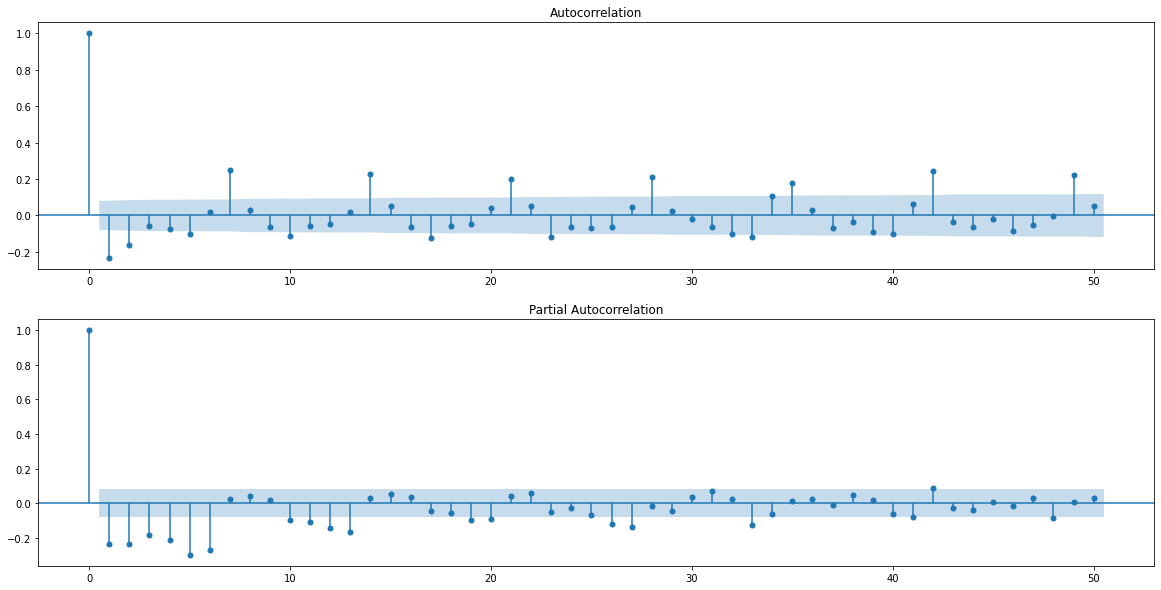

In [6]:
#we use train.diff()(differenced data), because this time series is unit root process.
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

From Autocorrelation, we can see that there's a recurring pattern every 7 periods, indicating a weekly pattern exists; hence p=7.
Since our time series data is stationary, no differencing is needed, so d=0.

# ARIMA Modeling
We will use SARIMAX but with seasonal_order = (0,0,0,0), so it has same result as ARIMA

In [7]:
# do a sample run to check and see if the dates are the dates we are looking for
arima = sm.tsa.statespace.SARIMAX(train, order=(0,0,0), freq='D', seasonal_order=(0,0,0,0), 
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
#get the prediction and forecast
pred = arima.predict(train_end,test_end)[1:]
print(pred)
fore = arima.predict(test_end, forecast_end)[1:]
print(fore)

2017-09-01    0.0
2017-09-02    0.0
2017-09-03    0.0
2017-09-04    0.0
2017-09-05    0.0
             ... 
2017-12-27    0.0
2017-12-28    0.0
2017-12-29    0.0
2017-12-30    0.0
2017-12-31    0.0
Freq: D, Length: 122, dtype: float64
2018-01-01    0.0
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
             ... 
2018-12-26    0.0
2018-12-27    0.0
2018-12-28    0.0
2018-12-29    0.0
2018-12-30    0.0
Freq: D, Length: 364, dtype: float64


# ARIMA gridsearch and metric score recording
#Grid search method for best parameters based on MSE, smape, and AIC of test and forecast
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []

#iternation
for p in range(8):
    for d in [0, 1]:
        for q in range(8):
            #fit the model
            arima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(0,0,0,0), 
                                              enforce_stationarity=False, enforce_invertibility=False,).fit()
            #get the prediction & future forecast for 2018
            pred = arima.predict(train_end,test_end)[1:]
            fore = arima.predict(test_end, forecast_end)[1:]

            #append the values (calculate)
            model_list.append('ARIMA')
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(mean_squared_error(test, pred))
            MAE_list.append(mean_absolute_error(test, pred))
            AIC_list.append(arima.aic)
            ForeMSE_list.append(mean_squared_error(baseline,fore))
            ForeMAE_list.append(mean_absolute_error(baseline,fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
arima_score_dict = {
    'model':model_list,
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}
arima_score_df = pd.DataFrame.from_dict(arima_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
arima_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arima_gridsearch.csv',
                      index=False)

# Auto_arima to search for best params
auto_arima(train, exogenous=None, 
           start_p=6, d=None, start_q=0, max_p=10, max_d=1, max_q=10, # grid search for order params
           start_P=0, D=None, start_Q=0, max_P=0, max_D=0, max_Q=0, m=0, #grid search for seasonal order params, seaonal=True
           max_order=21, seasonal=False, stationary=True, information_criterion='aic', suppress_warnings=True) 
#maxorder = allowed sum of p and q, since an year has 12 months, so we'll have 11 as max for p, 10 for q
#data already stationary so stationary=True

#**Result order=(10,0,0)**

# ARMA order select to search for best params
resDiff = sm.tsa.arma_order_select_ic(train, max_ar=10, max_ma=10, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

#**Result p=8, q=8, d has to be 0, since it's designed for ARMA**

# Recording the scores from auto arima and order select
model_list = []
p_list = []
d_list = []
q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []

#iternation
for p in [8,10]:
    for d in [0]:
        for q in [0,8]:
            #fit the model
            arima = sm.tsa.statespace.SARIMAX(train, order=(p,0,q), freq='D', seasonal_order=(0,0,0,0), 
                                              enforce_stationarity=False, enforce_invertibility=False,).fit()
            #get the prediction & future forecast for 2018
            pred = arima.predict(train_end,test_end)[1:]
            fore = arima.predict(test_end, forecast_end)[1:]

            #append the values (calculate)
            model_list.append('ARIMAX')
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(mean_squared_error(test, pred))
            MAE_list.append(mean_absolute_error(test, pred))
            AIC_list.append(arima.aic)
            ForeMSE_list.append(mean_squared_error(baseline,fore))
            ForeMAE_list.append(mean_absolute_error(baseline,fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
arima_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}
arima_score_df = pd.DataFrame.from_dict(arima_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
arima_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\auto_arima_order_select.csv',
                      index=False)

In [42]:
#need to change working directory to figure so we can save the figures in its folder
path="C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\figures"
os.chdir(path)

In [43]:
# create a function to take in the order parameters for ARIMA, fit, plot diagnostics, display metrics scores,
# plot the test vs predict and save all figures
def ARIMA101(p, d, q):
    #fit the model with given params
    arima = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0), freq='D',
                                      enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    arima.plot_diagnostics(figsize=(15, 12))
    plt.savefig('arima{}_diagnostics.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    #predict using the model
    pred = arima.predict(train_end,test_end)[1:]
    fore = arima.predict(test_end,forecast_end)[1:]
    #print the current model's metric scores
    print('ARIMA{} model test MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(test,pred))
    print('ARIMA{} model test MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(test,pred))
    print('ARIMA{} model AIC:'.format(str(p)+str(d)+str(q)), arima.aic)
    print('ARIMA{} model forecast MSE:'.format(str(p)+str(d)+str(q)), mean_squared_error(baseline,fore))
    print('ARIMA{} model forecast MAE:'.format(str(p)+str(d)+str(q)), mean_absolute_error(baseline,fore))

    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
    plt.suptitle('ARIMA{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)))
    plt.legend(["Test", "Predict", "Baseline", "Forecast"])
    plt.savefig('arima{}_test_pred.png'.format(str(p)+str(d)+str(q)))
    plt.show()
    return

In [40]:
# load and concat the arima metric scores
arima_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arima_gridsearch.csv')
arima_df2 = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\auto_arima_order_select.csv')
arima_dfs = pd.concat([arima_df, arima_df2], ignore_index=True)

In [44]:
# find the top 3 of each scoring category
display(arima_dfs.sort_values('MSE').head(3))

model  p  d  q           MSE         MAE          AIC        ForeMSE  \
84  ARIMA  5  0  4  56829.626466  179.603289  8152.927942  231241.552617   
68  ARIMA  4  0  4  61836.375756  187.922127  8109.478887  180583.026064   
96  ARIMA  6  0  0  62646.299520  195.102267  8182.390450  174484.947090   

       ForeMAE  
84  419.334757  
68  368.793125  
96  357.215893

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


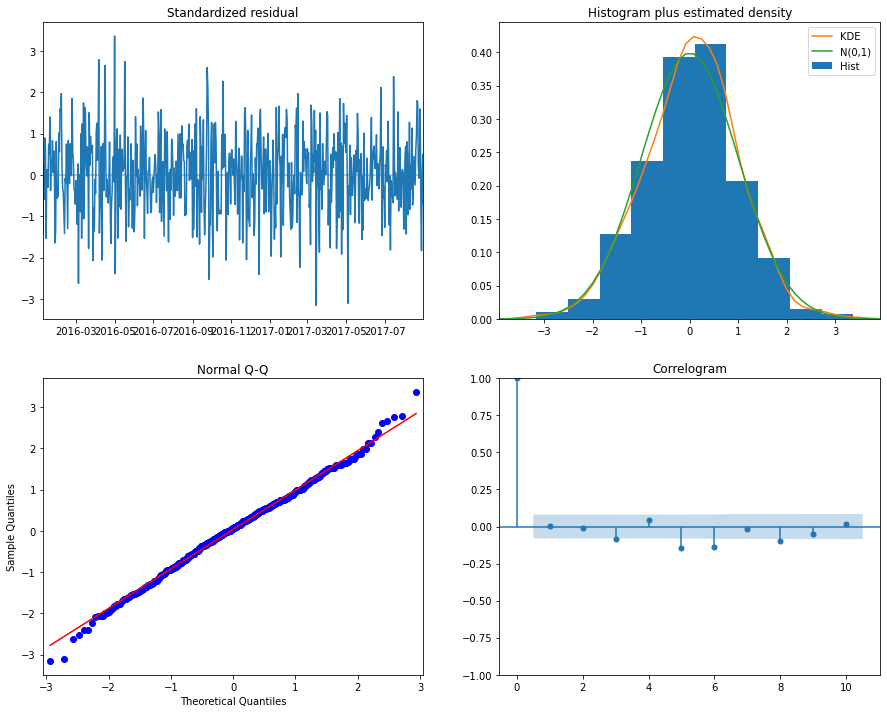

ARIMA504 model test MSE: 56829.626465548456
ARIMA504 model test MAE: 179.6032886724129
ARIMA504 model AIC: 8152.927941745487
ARIMA504 model forecast MSE: 231241.55261686663
ARIMA504 model forecast MAE: 419.3347570031445


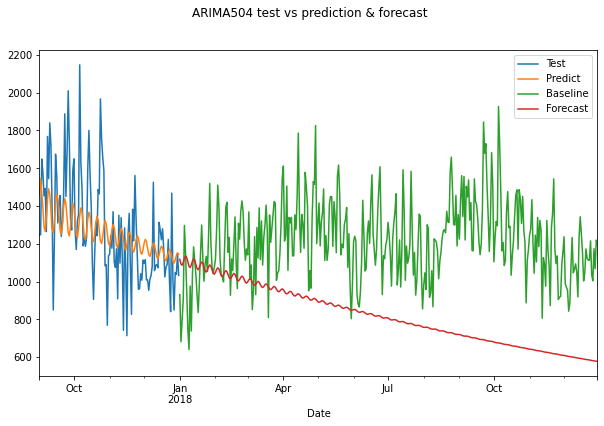

In [45]:
ARIMA101(5,0,4) #lowest MSE and MAE

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the top right plot, we see that the KDE line follows pretty close with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). This is also an indication that the residuals are normally distributed.

The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


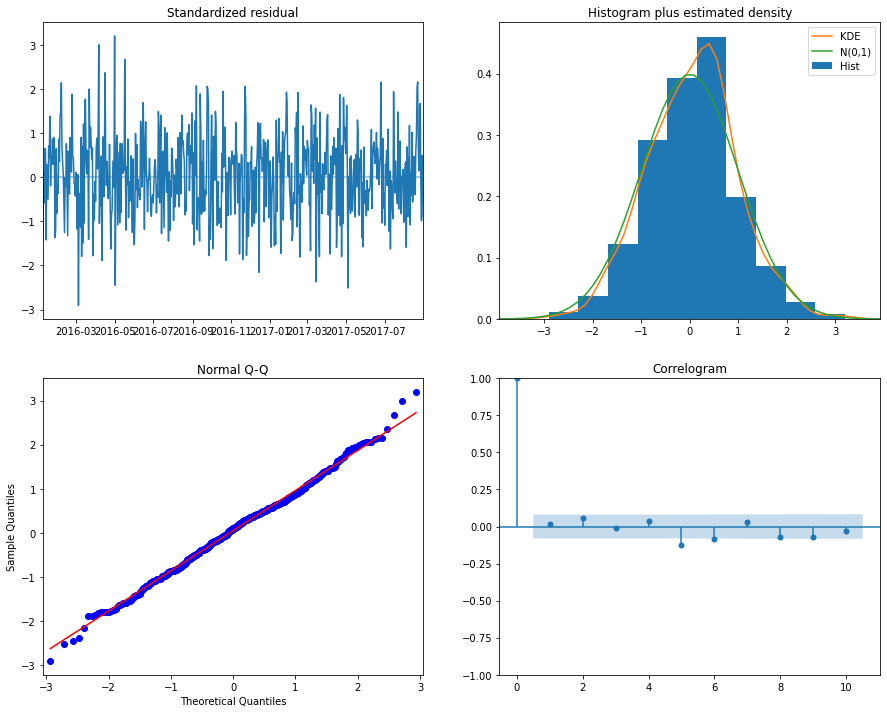

ARIMA404 model test MSE: 61836.375755774265
ARIMA404 model test MAE: 187.9221274993271
ARIMA404 model AIC: 8109.478887365134
ARIMA404 model forecast MSE: 180583.0260638822
ARIMA404 model forecast MAE: 368.79312486353507


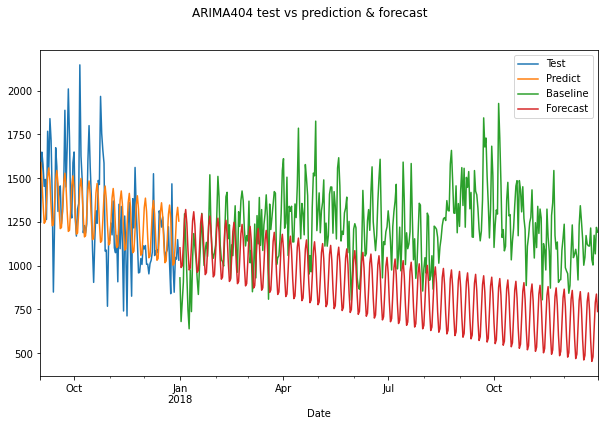

In [46]:
ARIMA101(4,0,4) # even though it's second in place, the ForeMSE is lower than 1st place

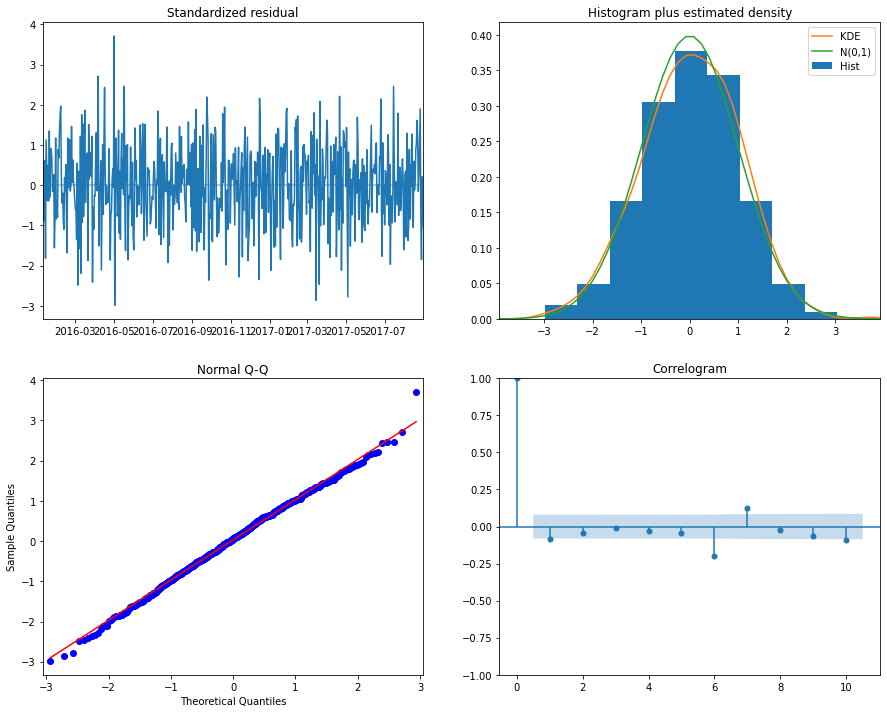

ARIMA600 model test MSE: 62646.29952011323
ARIMA600 model test MAE: 195.1022665152943
ARIMA600 model AIC: 8182.390450165786
ARIMA600 model forecast MSE: 174484.9470903905
ARIMA600 model forecast MAE: 357.2158931752744


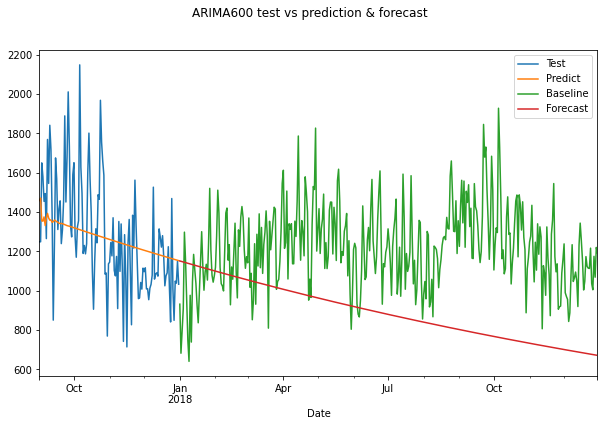

In [47]:
ARIMA101(6,0,0)

In [48]:
display(arima_dfs.sort_values('MAE').head(3))
display(arima_dfs.sort_values('AIC').head(3))
display(arima_dfs.sort_values('ForeMSE').head(3))
display(arima_dfs.sort_values('ForeMAE').head(3))

model  p  d  q           MSE         MAE          AIC        ForeMSE  \
84  ARIMA  5  0  4  56829.626466  179.603289  8152.927942  231241.552617   
68  ARIMA  4  0  4  61836.375756  187.922127  8109.478887  180583.026064   
98  ARIMA  6  0  2  67264.432566  188.438683  8150.271316  488334.961678   

       ForeMAE  
84  419.334757  
68  368.793125  
98  641.654330

model   p  d  q           MSE         MAE          AIC       ForeMSE  \
131  ARIMA  10  0  8  80994.277510  225.060880  8010.731141  41186.082020   
127  ARIMA   7  1  7  81600.114016  229.085354  8023.303576  45572.117917   
129  ARIMA   8  0  8  86396.395890  236.983154  8025.733352  72686.517220   

        ForeMAE  
131  164.234482  
127  174.296090  
129  227.607350

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
126  ARIMA  7  1  6  82700.860481  222.524098  8038.590400  34966.929421   
125  ARIMA  7  1  5  82350.514643  221.577906  8042.803366  35058.929130   
59   ARIMA  3  1  3  78462.712493  220.622860  8110.366953  35846.191049   

        ForeMAE  
126  145.977588  
125  146.219253  
59   150.547041

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
126  ARIMA  7  1  6  82700.860481  222.524098  8038.590400  34966.929421   
125  ARIMA  7  1  5  82350.514643  221.577906  8042.803366  35058.929130   
59   ARIMA  3  1  3  78462.712493  220.622860  8110.366953  35846.191049   

        ForeMAE  
126  145.977588  
125  146.219253  
59   150.547041

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


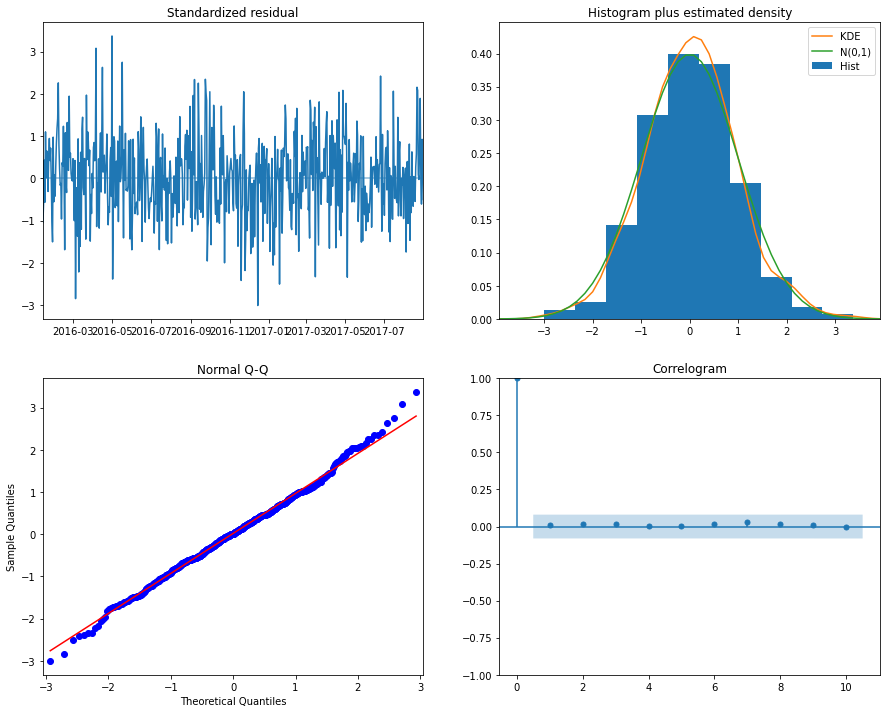

ARIMA1008 model test MSE: 80994.27750632312
ARIMA1008 model test MAE: 225.0608795741459
ARIMA1008 model AIC: 8010.731141038063
ARIMA1008 model forecast MSE: 41186.082017463836
ARIMA1008 model forecast MAE: 164.23448221066363


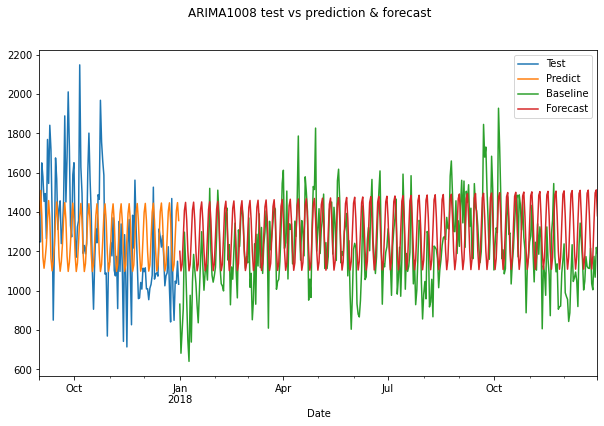

In [49]:
ARIMA101(10,0,8)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


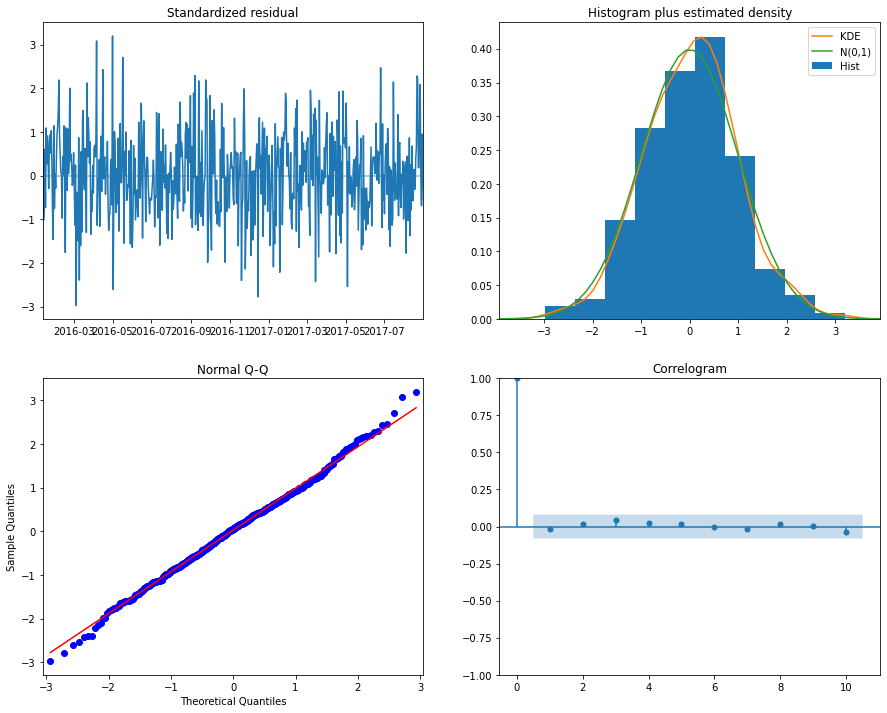

ARIMA717 model test MSE: 81600.11401631052
ARIMA717 model test MAE: 229.0853538405574
ARIMA717 model AIC: 8023.30357594755
ARIMA717 model forecast MSE: 45572.117917263284
ARIMA717 model forecast MAE: 174.296090341643


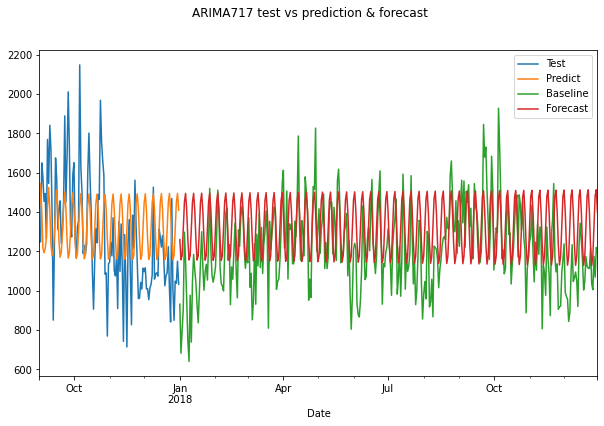

In [50]:
ARIMA101(7,1,7)

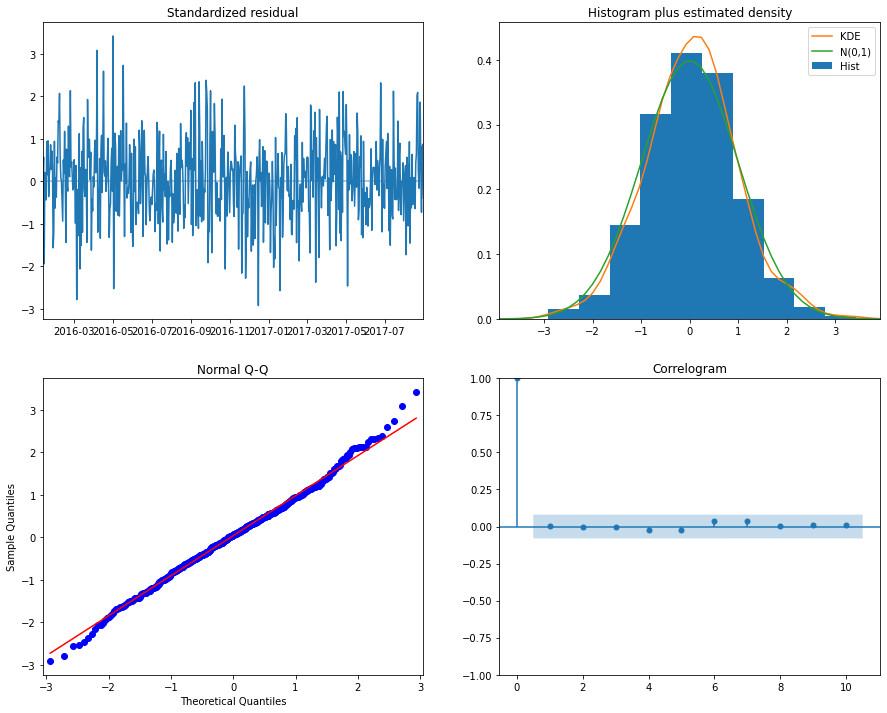

ARIMA716 model test MSE: 82700.8604808647
ARIMA716 model test MAE: 222.524097763027
ARIMA716 model AIC: 8038.59040017368
ARIMA716 model forecast MSE: 34966.92942073181
ARIMA716 model forecast MAE: 145.9775884813462


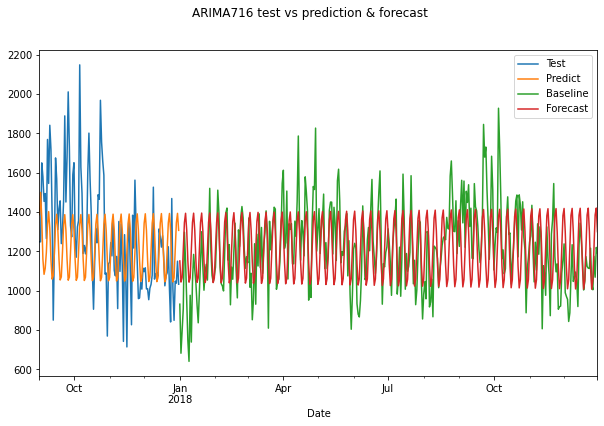

In [51]:
ARIMA101(7,1,6)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


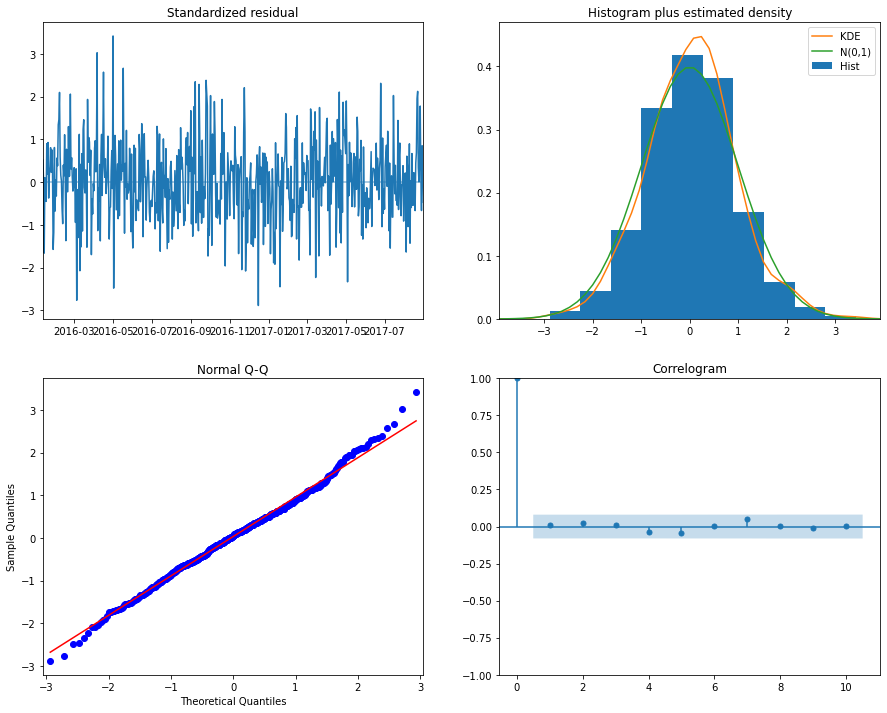

ARIMA715 model test MSE: 82350.51464265438
ARIMA715 model test MAE: 221.57790625112958
ARIMA715 model AIC: 8042.803366206579
ARIMA715 model forecast MSE: 35058.929130066455
ARIMA715 model forecast MAE: 146.21925342145454


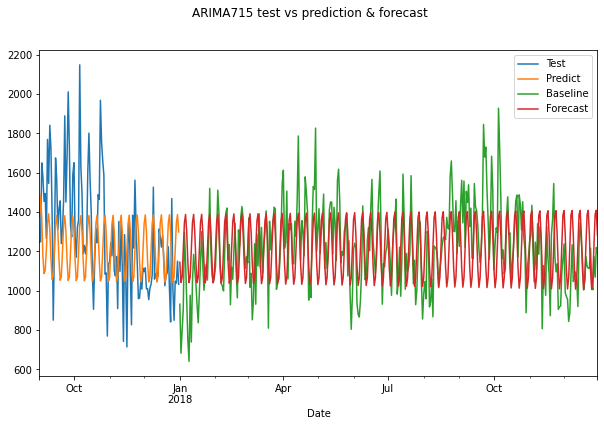

In [52]:
ARIMA101(7,1,5)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


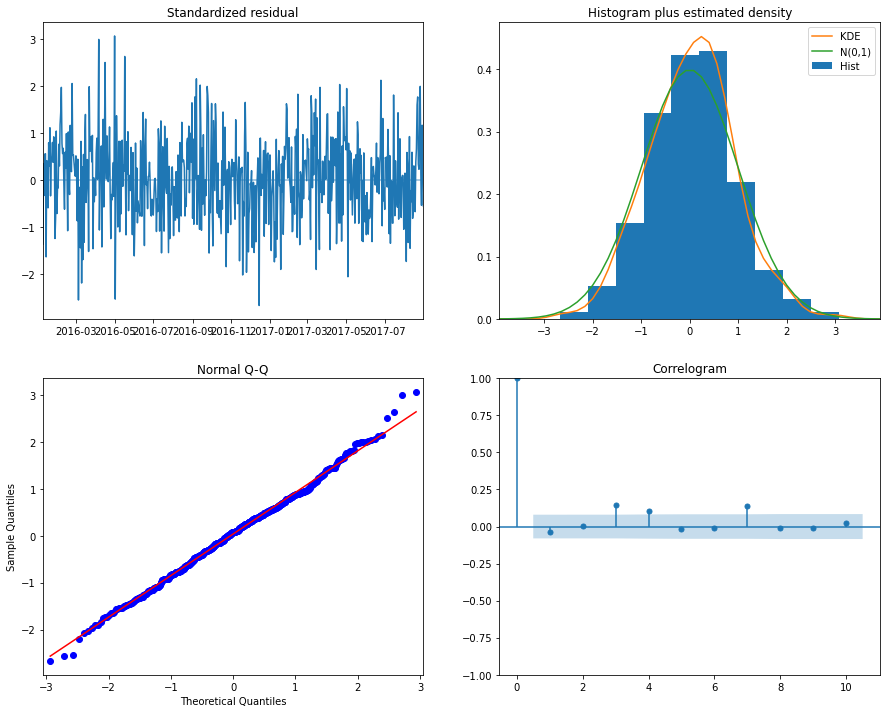

ARIMA313 model test MSE: 78462.71249342342
ARIMA313 model test MAE: 220.62286000732644
ARIMA313 model AIC: 8110.36695330462
ARIMA313 model forecast MSE: 35846.19104929065
ARIMA313 model forecast MAE: 150.54704072194943


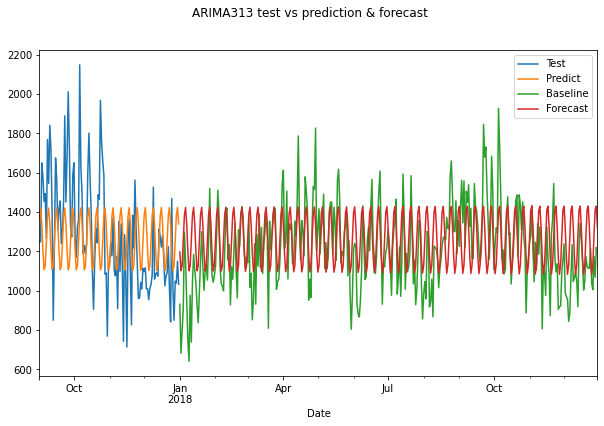

In [53]:
ARIMA101(3,1,3)

Even though the ARIMA can capture the weekly periodicity, it totally failed the yearly seasonality, which we can see obviously by views the forecast vs baseline figures.

# SARIMA
The method is suitable for univariate time series with trend and/or seasonal components.
Let's check and see which parameters from ARIMA gave best result and take the order params from them.

In [ ]:
# SARIMA gridsearch and metric score recording
#Grid search method for best parameters based on MSE, smape, and AIC of test and forecast
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []

#iternation
for p in range(7):
    for d in [0, 1]:
        for q in range(7):
            for P in range(3):
                for D in range(2):
                    for Q in range(3):
                        #fit the model
                        model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(P,D,Q,7), 
                                                          enforce_stationarity=False, enforce_invertibility=False,).fit()
                        #get the prediction & future forecast for 2018
                        pred = model.predict(train_end,test_end)[1:]
                        fore = model.predict(test_end, forecast_end)[1:]

                        #append the values (calculate)
                        model_list.append('SARIMA')
                        p_list.append(p)
                        d_list.append(d)
                        q_list.append(q)
                        P_list.append(P)
                        D_list.append(D)
                        Q_list.append(Q)
                        MSE_list.append(mean_squared_error(test, pred))
                        MAE_list.append(mean_absolute_error(test, pred))
                        AIC_list.append(arima.aic)
                        ForeMSE_list.append(mean_squared_error(baseline,fore))
                        ForeMAE_list.append(mean_absolute_error(baseline,fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
model_score_dict = {
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'P': P_list,
    'D': D_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}
model_score_df = pd.DataFrame.from_dict(model_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
model_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarima_gridsearch.csv',
                      index=False)

In [58]:
# create a function to take in model name and the parameters for SARIMAX, fit, plot diagnostics,
# plot the test vs predict and save the figure
def SARIMA101(p, d, q, P, D, Q):
    #fit the model with given params
    model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(P,D,Q,7),
                                      enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    model.plot_diagnostics(figsize=(15, 12))
    plt.show()
    #forecasts
    pred = model.predict(train_end,test_end)[1:]
    fore = model.predict(test_end, forecast_end)[1:]
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
    plt.suptitle('SARIMA{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    plt.legend(["Test", "Predict", "Baseline", "Forecast"])
    plt.savefig('sarima{}_test_pred.png'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)))
    plt.show()
    return

In [56]:
# load the grid search data most params 0-3, D=0,1 d=0
sarima_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarima_gridsearch.csv')
display(sarima_score_df.sort_values('MSE').head(3))

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
1332  SARIMA  5  0  4  0  0  0  56829.62647  179.603289  8023.303576   
66    SARIMA  0  0  3  2  0  0  59874.53677  185.910845  8023.303576   
84    SARIMA  0  0  4  2  0  0  60118.32101  188.336836  8023.303576   

          ForeMSE     ForeMAE  
1332  231241.5526  419.334757  
66    325822.8032  514.250860  
84    285464.6856  477.520870

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


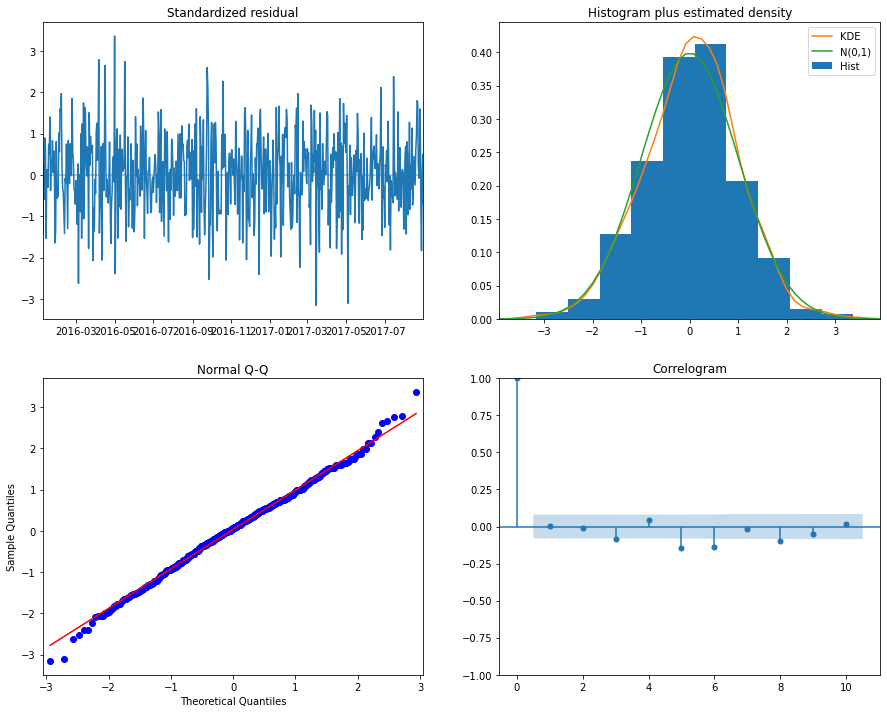

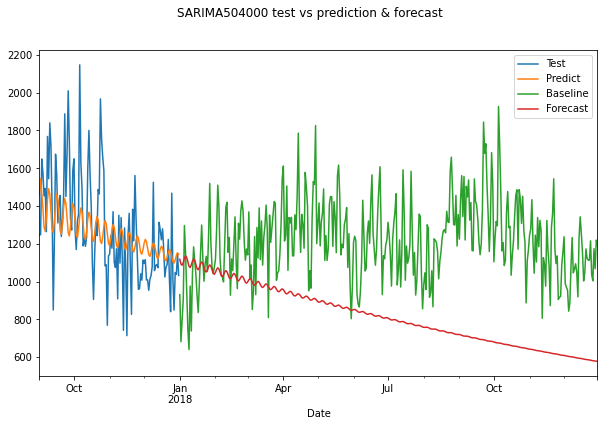

In [59]:
SARIMA101(5,0,4,0,0,0) # lowest MSE, we'll skip 2nd and 3rd since their ForeMSE isn't any better

In [60]:
display(sarima_score_df.sort_values('MAE').head(3)) #ignore all, we did 504000, which has much better overall scores

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
272   SARIMA  1  0  1  0  0  2  61137.53290  178.749824  8023.303576   
1332  SARIMA  5  0  4  0  0  0  56829.62647  179.603289  8023.303576   
1514  SARIMA  6  0  0  0  0  2  64593.05073  182.823535  8023.303576   

          ForeMSE     ForeMAE  
272   355415.8225  536.192121  
1332  231241.5526  419.334757  
1514  445342.4416  609.081667

In [65]:
sarima_score_df.sort_values('AIC').head(3) #the MSE and ForeMSE are way too high, ignore all

model  p  d  q  P  D  Q           MSE          MAE          AIC  \
0     SARIMA  0  0  0  0  0  0  1.712959e+06  1278.711419  8023.303576   
1182  SARIMA  4  1  2  2  0  0  7.486197e+04   210.686355  8023.303576   
1181  SARIMA  4  1  2  1  1  2  8.975650e+04   244.468633  8023.303576   

           ForeMSE      ForeMAE  
0     1.521735e+06  1216.378437  
1182  4.216095e+04   161.442008  
1181  9.535963e+04   265.096996

In [72]:
display(sarima_score_df.sort_values('ForeMSE').head(3))
sarima_score_df.sort_values('ForeMAE').head(3)
# we will try the best ForeMSE and best ForeMAE score's parameters

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
556  SARIMA  2  0  2  2  1  1  81987.34227  222.601272  8023.303576   
592  SARIMA  2  0  4  2  1  1  83171.92960  224.172635  8023.303576   
622  SARIMA  2  0  6  1  1  1  80224.64648  220.620797  8023.303576   

         ForeMSE     ForeMAE  
556  30691.31488  137.340165  
592  30715.00018  137.282622  
622  30741.45159  136.999826

model  p  d  q  P  D  Q          MSE         MAE          AIC  \
622  SARIMA  2  0  6  1  1  1  80224.64648  220.620797  8023.303576   
809  SARIMA  3  0  2  2  1  2  81510.94836  222.852715  8023.303576   
803  SARIMA  3  0  2  1  1  2  81101.90909  222.084643  8023.303576   

         ForeMSE     ForeMAE  
622  30741.45159  136.999826  
809  30830.43351  137.218813  
803  30799.15273  137.256071

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


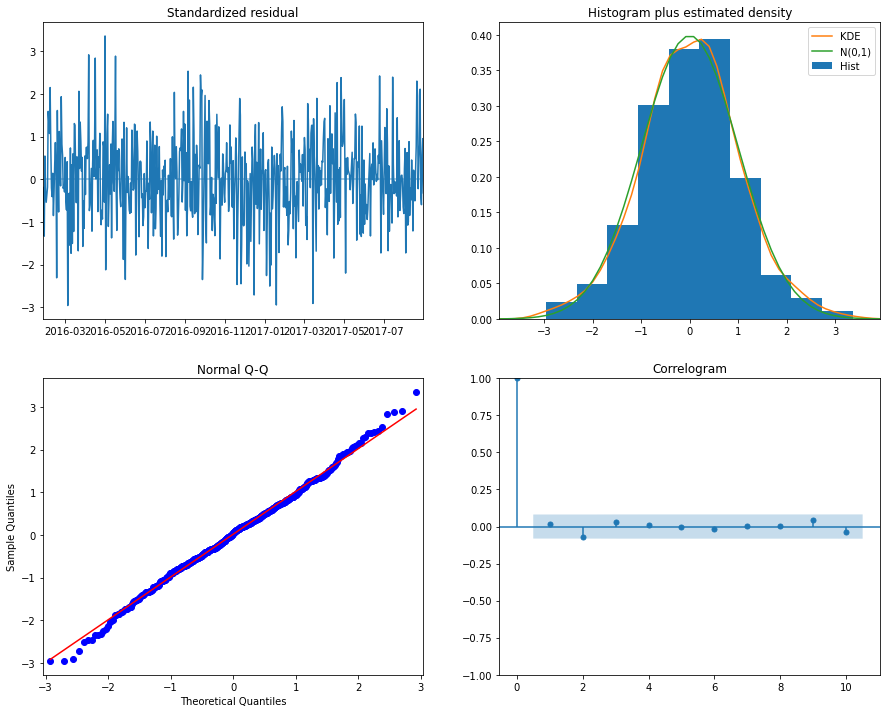

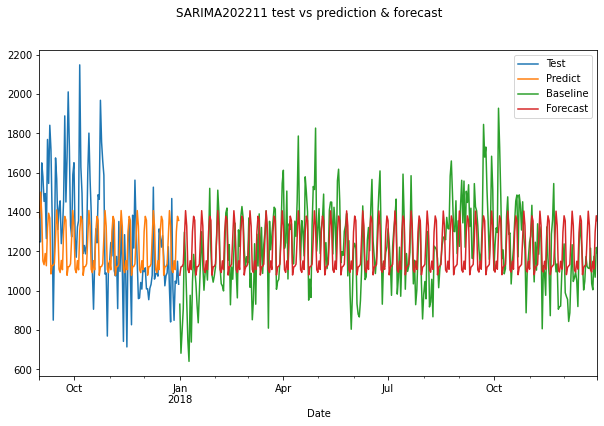

In [67]:
SARIMA101(2,0,2,2,1,1)

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


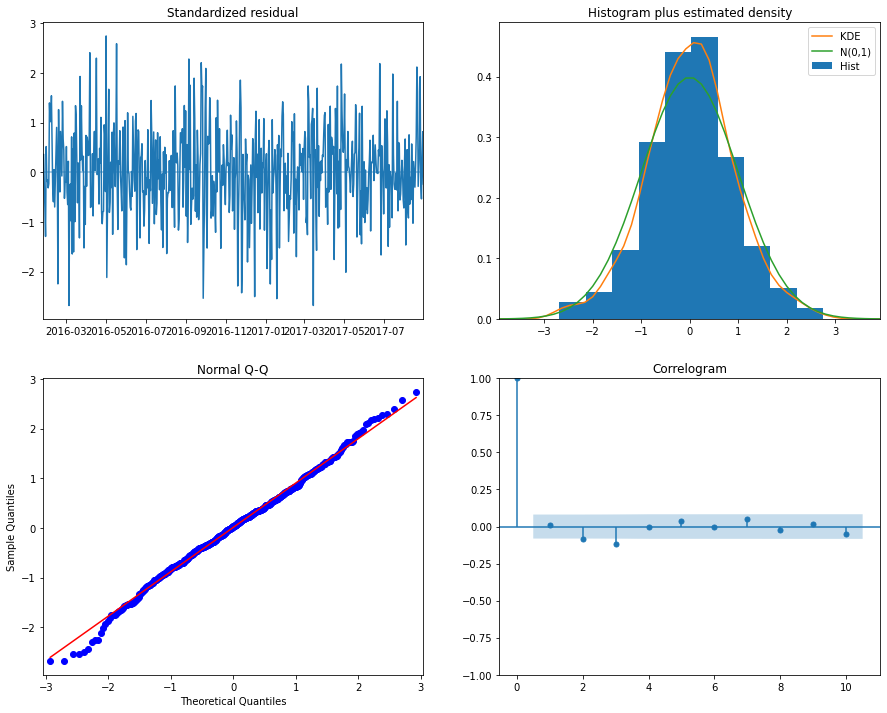

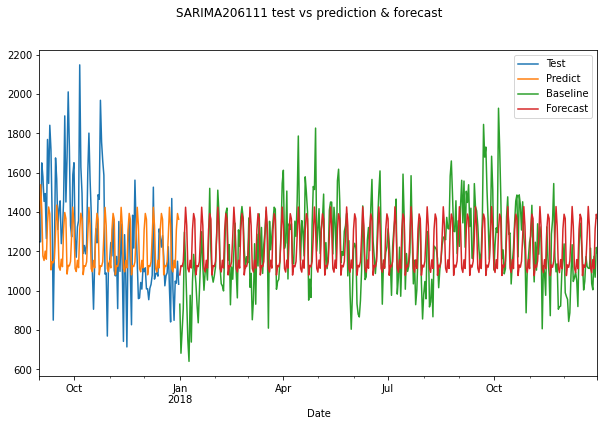

In [69]:
SARIMA101(2,0,6,1,1,1)

Unfortunately, SARIMA also fails to capture the yearly seasonality.

# Holtwinters ExponentialSmoothing
This method is suitable for univariate time series with trend and/or seasonal components.

# HES gridsearch and metric score recording
#create empty lists to store values
model_list = []
trend_list = []
seasonal_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []
#iternation
for trnd in [None, 'add', 'mul']:
    for season in [None, 'add', 'mul']:
        # fit the model, trend is constant number which should be daily average sales
        model = ExponentialSmoothing(train, freq='D', seasonal_periods=7 ,trend=trnd, seasonal=season).fit()
        # get the prediction
        pred = model.predict(train_end,test_end)[1:]
        fore = model.predict(test_end, forecast_end)[1:]
        # append the values (calculate)
        model_list.append('HES')
        trend_list.append(trnd)
        seasonal_list.append(season)
        MSE_list.append(mean_squared_error(test,pred))
        MAE_list.append(mean_absolute_error(test,pred))
        AIC_list.append(model.aic)
        ForeMSE_list.append(mean_squared_error(baseline, fore))
        ForeMAE_list.append(mean_absolute_error(baseline, fore))

#create a dict to store the key:values then change to dataframe for easier/cleaner access
model_score_dict = {
    'model':model_list
    'trend': trend_list,
    'seasonal': seasonal_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE': ForeMSE_list,
    'ForeMAE': ForeMAE_list,
}

model_score_df = pd.DataFrame.from_dict(model_score_dict)
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
model_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\HES_gridsearch.csv',
                      index=False)

In [74]:
HES_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\HES_gridsearch.csv')
display(HES_score_df.sort_values('MSE').head(3))
display(HES_score_df.sort_values('MAE').head(3))
display(HES_score_df.sort_values('AIC').head(3))
display(HES_score_df.sort_values('ForeMSE').head(3))
display(HES_score_df.sort_values('ForeMAE').head(3))

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   
0   HES   NaN      NaN  89995.68355  253.103487  6606.397791  71919.12757   

      ForeMAE  
8  147.751599  
6  216.991997  
0  222.103804

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
7   HES   mul      add  92055.30826  249.775821  6464.360256  40250.20055   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   

      ForeMAE  
8  147.751599  
7  158.159609  
6  216.991997

model trend seasonal          MSE         MAE          AIC       ForeMSE  \
1   HES   NaN      add  100748.4621  264.351634  6396.864806   73266.19453   
4   HES   add      add  126638.1387  299.428095  6400.912708  232989.56700   
2   HES   NaN      mul  105724.3640  270.111040  6403.000551   76676.32926   

      ForeMAE  
1  229.550888  
4  446.579345  
2  234.837518

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
7   HES   mul      add  92055.30826  249.775821  6464.360256  40250.20055   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   

      ForeMAE  
8  147.751599  
7  158.159609  
6  216.991997

model trend seasonal          MSE         MAE          AIC      ForeMSE  \
8   HES   mul      mul  86502.78930  241.075128  6406.942792  36919.07925   
7   HES   mul      add  92055.30826  249.775821  6464.360256  40250.20055   
6   HES   mul      NaN  89300.28125  251.926869  6611.385094  69220.06911   

      ForeMAE  
8  147.751599  
7  158.159609  
6  216.991997

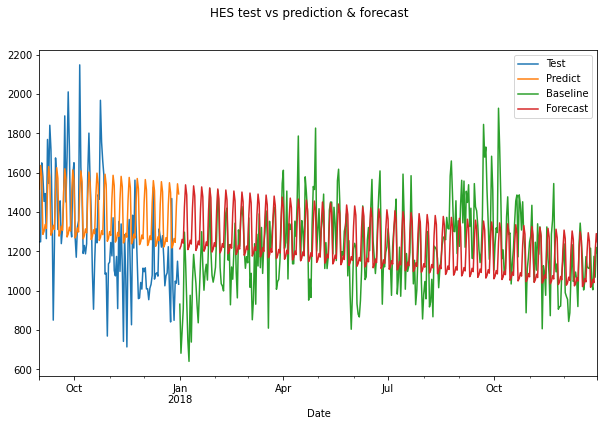

In [77]:
# trend mul anad seasonal mul seems to be the winner, let's fit and...etc
HES = ExponentialSmoothing(train, freq='D', seasonal_periods=7 ,trend='mul', seasonal='mul').fit()
# get the prediction
pred = HES.predict(train_end,test_end)[1:]
fore = HES.predict(test_end, forecast_end)[1:]
#view the plot of test vs pred
pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
plt.suptitle('HES test vs prediction & forecast')
plt.legend(["Test", "Predict", "Baseline", "Forecast"])
plt.savefig('HES_test_pred.png')
plt.show()

Worse than ARIMA/SARIMA

# TBATS
Trigonometric regressors to model multiple-seasonalities
Box-Cox transformations
ARMA errors
Trend
Seasonality

In [10]:
# Fit the model, seasonal_periods=(7, 364) for two seasonalities, 7 for weekly,
# and 364 for yearly since we have 364 rows per year of data
tbats = TBATS(seasonal_periods=(7, 364)).fit(train)

In [11]:
# Forecast days ahead
pred = tbats.forecast(steps=(len(test)))
fore = tbats.forecast(steps=(len(test)+364))

TBATS model MSE: 79309.45155101312
TBATS model MAE: 234.27815922676487
TBATS model AIC: 10264.989853974386
TBATS model ForeMSE: 36964.783072012375
TBATS model ForeMAE: 155.65340785623306


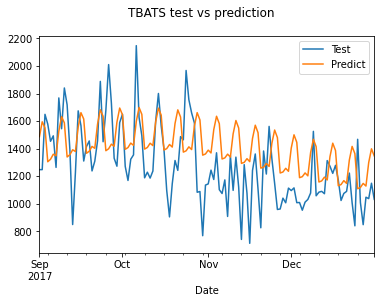

In [12]:
print('TBATS model MSE:', mean_squared_error(test,pred))
print('TBATS model MAE:', mean_absolute_error(test,pred))
print('TBATS model AIC:', tbats.aic)
print('TBATS model ForeMSE:', mean_squared_error(baseline,fore[122:]))
print('TBATS model ForeMAE:', mean_absolute_error(baseline,fore[122:]))
#view the plot of test vs pred
pd.DataFrame({'test':test,'pred':pred}).plot()
plt.suptitle('TBATS test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('TBATS_test_pred.png')
plt.show()

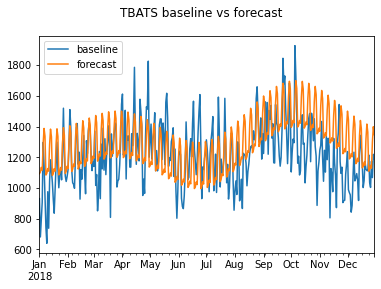

In [13]:
#view the 2018 forecast
pd.DataFrame({'baseline':baseline, 'forecast':fore[122:]}).plot()
plt.suptitle('TBATS baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('TBATS_baseline_forecast.png')
plt.show()

In [20]:
#create a dataframe and save the scores
TBATS_df = pd.DataFrame({
    'model':'TBATS',
    'MSE':mean_squared_error(test,pred),
    'MAE':mean_absolute_error(test,pred),
    'AIC':tbats.aic,
    'ForeMSE':mean_squared_error(baseline,fore[122:]),
    'ForeMAE':mean_absolute_error(baseline,fore[122:])}, index=[0])
TBATS_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS.csv',
                index=False)

The metric scores isn't as good as other models, but this model captures the weekly periodicity AND yearly seaonality!

# ARIMAX
ARIMA with features

In [78]:
# creating a new dataframe with additional date so we can do forecast
# since it's univariate, we will take the df2 daily sales, then just append 1s for the rest of the sales
Date = pd.date_range('2016-01-04', periods=1092, freq='D')
daily_list = list(df2.Daily)
for i in range(len(Date)-len(daily_list)):
    daily_list.append(1)
buf = {'Daily':daily_list}
buf = pd.DataFrame.from_dict(buf)
buf = buf.set_index(Date)

#month one hot encoding
buf['month'] = buf.index.month
month_dummies = pd.get_dummies(buf['month'])
month_dummies.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
buf = pd.concat([buf, month_dummies], axis=1).drop(['month'],axis=1)
#dayofweek one hot encoding
buf['dayofweek'] = buf.index.weekday
week_dummies = pd.get_dummies(buf['dayofweek'])
week_dummies.columns = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
buf = pd.concat([buf, week_dummies], axis=1).drop(['dayofweek'],axis=1)
#defining exog_train and test and forecast
exog_train = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                  'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2016-01-04':'2017-08-31'].dropna()
exog_test = buf[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec',
                 'Mon','Tue','Wed','Thu','Fri','Sat','Sun']]['2017-09-01':'2018-12-30'].dropna()

In [80]:
# check the forecast dates
model = sm.tsa.statespace.SARIMAX(train, order=(0,0,0), seasonal_order=(0,0,0,0), freq='D', exog=exog_train,
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
forecast[:122] #use this to calcualate metrics for test, needs 9/1~12/31 of 2017

2017-09-01    1380.565402
2017-09-02    1482.264025
2017-09-03    1434.636763
2017-09-04    1181.035148
2017-09-05    1194.345796
                 ...     
2017-12-27     998.171635
2017-12-28     984.584870
2017-12-29    1151.655512
2017-12-30    1253.354135
2017-12-31    1205.726873
Freq: D, Length: 122, dtype: float64

In [81]:
forecast[122:] # use this to calculate metrics for 2018 1/1-12/30 (364 days)

2018-01-01     920.630298
2018-01-02     933.940946
2018-01-03     966.676675
2018-01-04     953.089910
2018-01-05    1120.160553
                 ...     
2018-12-26     998.171635
2018-12-27     984.584870
2018-12-28    1151.655512
2018-12-29    1253.354135
2018-12-30    1205.726873
Freq: D, Length: 364, dtype: float64

In [ ]:
# Grid search for best params and record metric scores
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []
#iternation
for p in range(8):
    for d in [0, 1]:
        for q in range(8):
            # fit the model, trend is constant number which should be daily average sales
            model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0), freq='D', exog=exog_train,
                                               enforce_stationarity=False, enforce_invertibility=False,).fit()
            # get the prediction
            forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
            pred = forecast[:122]
            fore = forecast[122:]
            # append the values (caculate)
            model_list.append('ARIMAX')
            p_list.append(p)
            d_list.append(d)
            q_list.append(q)
            MSE_list.append(mean_squared_error(test,pred))
            MAE_list.append(mean_absolute_error(test,pred))
            AIC_list.append(model.aic)
            ForeMSE_list.append(mean_squared_error(baseline,fore))
            ForeMAE_list.append(mean_absolute_error(baseline,fore))
            #create a dataframe to store the scores
arimax_score_df = pd.DataFrame({
    'model':model_list,
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE':ForeMSE_list,
    'ForeMAE':ForeMAE_list})
arimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv',
                      index=False)

In [92]:
arimax_score_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv')
display(arimax_score_df.sort_values('MSE').head(3))
display(arimax_score_df.sort_values('MAE').head(3))
display(arimax_score_df.sort_values('AIC').head(3))
display(arimax_score_df.sort_values('ForeMSE').head(3))
display(arimax_score_df.sort_values('ForeMAE').head(3))

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
83  ARIMAX  5  0  3  65873.074606  193.495806  8029.195843  22576.327364   
99  ARIMAX  6  0  3  65981.493356  193.961844  8020.130097  22725.925348   
82  ARIMAX  5  0  2  65981.923235  192.744925  8030.793798  22531.454958   

       ForeMAE  
83  116.106628  
99  116.402870  
82  116.919819

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
0   ARIMAX  0  0  0  66016.766390  192.521422  8166.199880  22544.877840   
1   ARIMAX  0  0  1  66075.969724  192.693170  8076.978941  22550.514650   
82  ARIMAX  5  0  2  65981.923235  192.744925  8030.793798  22531.454958   

       ForeMAE  
0   116.979432  
1   116.997730  
82  116.919819

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
7   ARIMAX  0  0  7  66296.743219  193.201030  7985.138949  22554.640898   
39  ARIMAX  2  0  7  70557.437849  200.809365  7986.163174  22570.373124   
23  ARIMAX  1  0  7  66251.964118  193.114894  7987.042372  22549.782058   

       ForeMAE  
7   117.006339  
39  117.002112  
23  117.002203

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
82  ARIMAX  5  0  2  65981.923235  192.744925  8030.793798  22531.454958   
51  ARIMAX  3  0  3  67385.958588  195.072834  8033.080664  22534.574832   
86  ARIMAX  5  0  6  67383.241912  195.066074  8002.977375  22539.110393   

       ForeMAE  
82  116.919819  
51  116.981630  
86  116.978753

model  p  d  q           MSE         MAE          AIC       ForeMSE  \
83  ARIMAX  5  0  3  65873.074606  193.495806  8029.195843  22576.327364   
84  ARIMAX  5  0  4  70054.189393  200.955517  8026.350145  22640.711729   
99  ARIMAX  6  0  3  65981.493356  193.961844  8020.130097  22725.925348   

       ForeMAE  
83  116.106628  
84  116.219088  
99  116.402870

In [93]:
# create a function to take in model name and the parameters for SARIMAX, fit, plot diagnostics,
# plot the test vs predict and save the figure
def SARIMAX101(p, d, q, P, D, Q, m):
    #fit the model with given params
    model = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), freq='D', seasonal_order=(P,D,Q,m), exog=exog_train, 
                                      enforce_stationarity=False, enforce_invertibility=False,).fit()
    #get the diagnostics for the model
    model.plot_diagnostics(figsize=(15, 12))
    plt.show()
    #forecasts
    forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
    pred = forecast[:122]
    fore = forecast[122:]
    #view the plot of test vs pred
    pd.DataFrame({'test':test,'pred':pred, 'baseline':baseline, 'forecast': fore}).plot(figsize=(10, 6))
    plt.suptitle('SARIMAX{} test vs prediction & forecast'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)+str(m)))
    plt.legend(["Test", "Predict", "Baseline", "Forecast"])
    plt.savefig('sarimax{}_test_pred.png'.format(str(p)+str(d)+str(q)+str(P)+str(D)+str(Q)+str(m)))
    plt.show()
    return

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


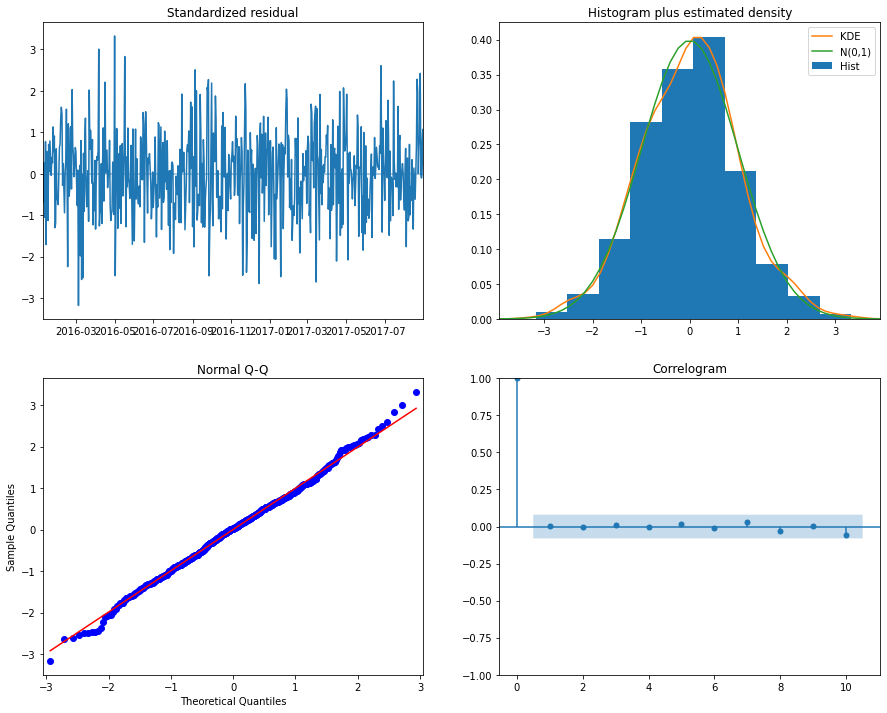

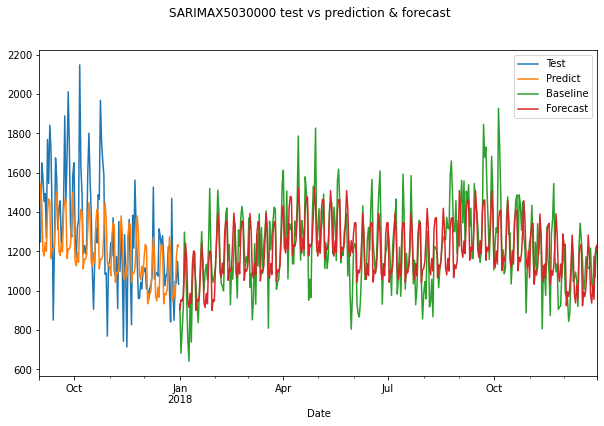

In [94]:
# we'll try the top score of each category
SARIMAX101(5,0,3,0,0,0,0) #top MSE and ForeMAE

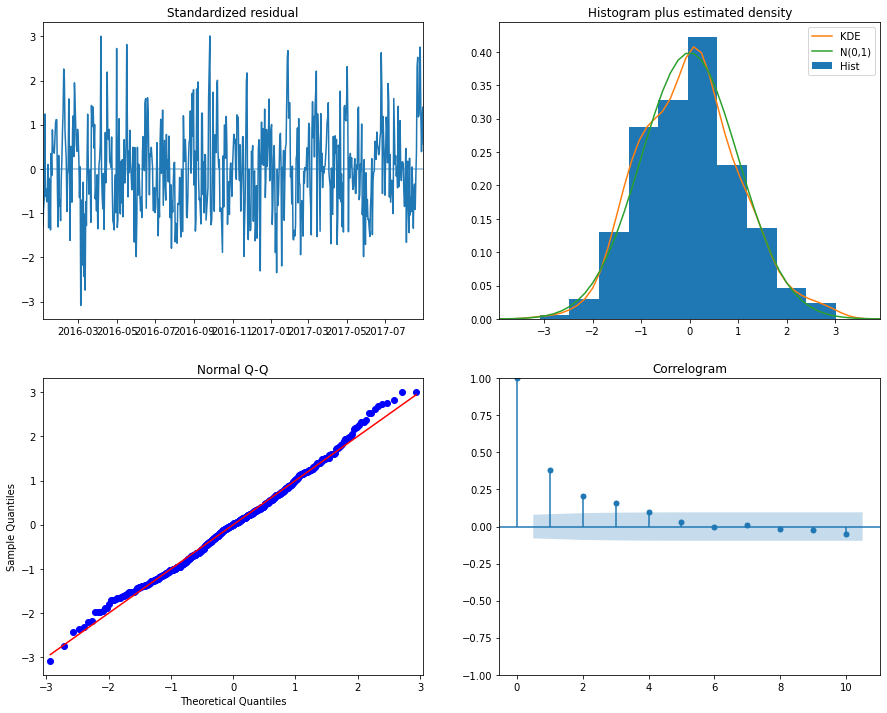

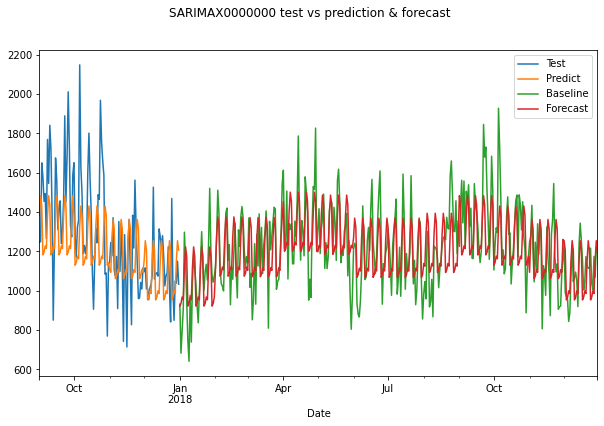

In [95]:
SARIMAX101(0,0,0,0,0,0,0) #top MAE

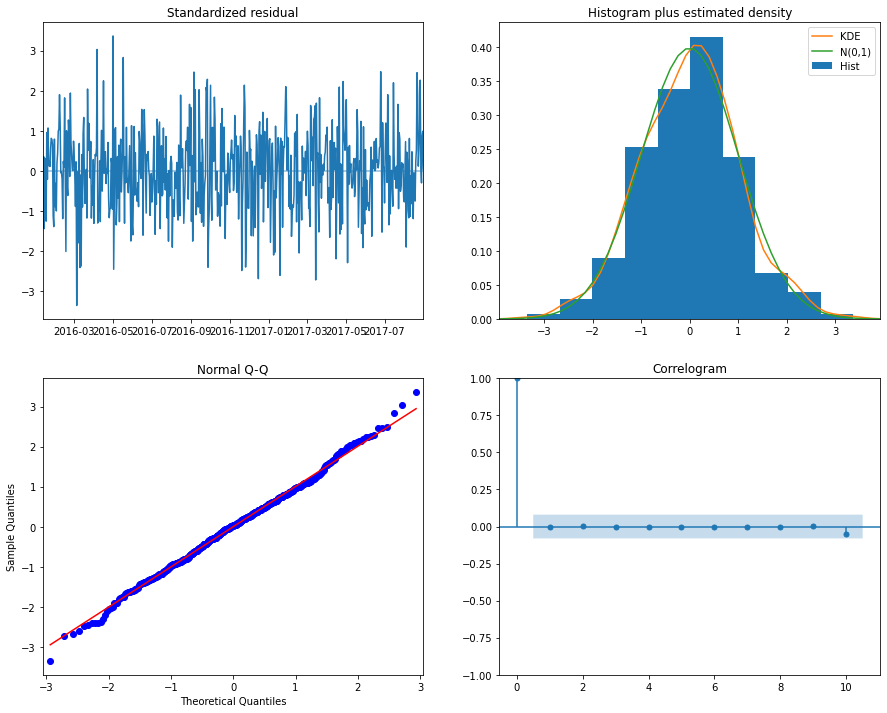

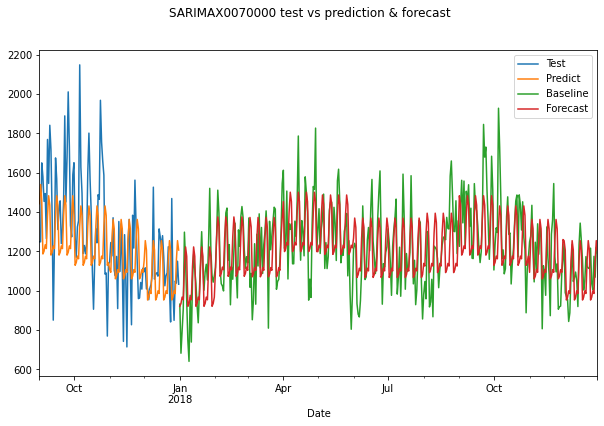

In [96]:
SARIMAX101(0,0,7,0,0,0,0) #top AIC

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


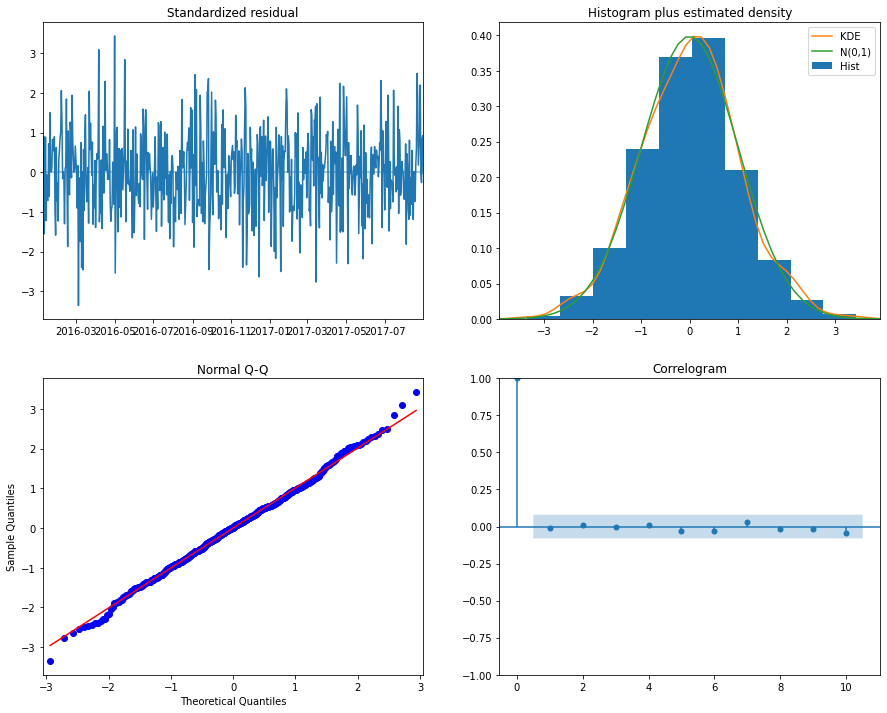

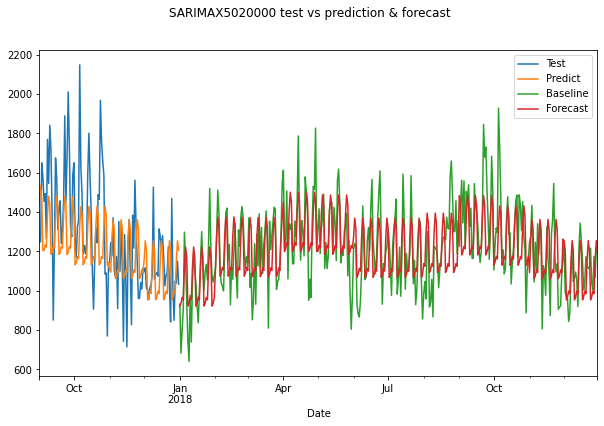

In [97]:
SARIMAX101(5,0,2,0,0,0,0) #top ForeMSE

The features helped a lot!

# SARIMAX

In [98]:
# Grid search for best params and record scores
#Since we are setting seasonality in weekly basis, m=7, it will influence order params so we need to adjust them as well
#we know d = 0 b/c dataset is stationary, we will leave it as it is.
#for SARIMAX the higher the order the slower it takes, we will evenly distribute to maximum order of 12; maximum p/P/q/Q=3
#D is usually 0 or 1
#create empty lists to store values
model_list = []
p_list = []
d_list = []
q_list = []
P_list = []
D_list = []
Q_list = []
MSE_list = []
MAE_list = []
AIC_list = []
ForeMSE_list = []
ForeMAE_list = []
#gridsearch iternation, since arima504 and arimax503 were top MSE scores in its model, i want to include p =5 and q=3,4
for p in [0,1,2,5]:
    for d in range(2):
        for q in range(5):
            for P in range(2):
                for D in [0,1]:
                    for Q in range(2):
                        # fit the model
                        sarimax = sm.tsa.statespace.SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,7), freq='D',
                                                            exog=exog_train,
                                                           enforce_stationarity=False, 
                                                           enforce_invertibility=False,).fit()
                        # forecasts
                        forecast = model.predict(train_end,forecast_end,exog = exog_test)[1:]
                        pred = forecast[:122]
                        fore = forecast[122:]
                        # append the values (calculate)
                        model_list.append('SARIMAX')
                        p_list.append(p)
                        d_list.append(d)
                        q_list.append(q)
                        P_list.append(P)
                        D_list.append(D)
                        Q_list.append(Q)
                        MSE_list.append(mean_squared_error(test,pred))
                        MAE_list.append(mean_absolute_error(test,pred))
                        AIC_list.append(sarimax.aic)
                        ForeMSE_list.append(mean_squared_error(baseline,fore))
                        ForeMAE_list.append(mean_absolute_error(baseline,fore))                   

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

In [99]:
#create a dataframe to store as csv
sarimax_score_df = pd.DataFrame({
    'model':model_list,
    'p': p_list,
    'd': d_list,
    'q': q_list,
    'P': P_list,
    'D': D_list,
    'Q': Q_list,
    'MSE': MSE_list,
    'MAE': MAE_list,
    'AIC': AIC_list,
    'ForeMSE':ForeMSE_list,
    'ForeMAE':ForeMAE_list})
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
sarimax_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv',
                       index=False)

In [101]:
sarimax_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv')
display(sarimax_score_df.sort_values('MSE').head(3))
display(sarimax_score_df.sort_values('MAE').head(3))
display(sarimax_score_df.sort_values('AIC').head(3))
display(sarimax_score_df.sort_values('ForeMSE').head(3))
display(sarimax_score_df.sort_values('ForeMAE').head(3))

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
0    SARIMAX  0  0  0  0  0  0  87532.518607  238.174542  8166.199880   
217  SARIMAX  2  1  2  0  0  1  87532.518607  238.174542  8005.041738   
216  SARIMAX  2  1  2  0  0  0  87532.518607  238.174542  8063.599398   

          ForeMSE     ForeMAE  
0    53177.444506  189.215869  
217  53177.444506  189.215869  
216  53177.444506  189.215869

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
0    SARIMAX  0  0  0  0  0  0  87532.518607  238.174542  8166.199880   
217  SARIMAX  2  1  2  0  0  1  87532.518607  238.174542  8005.041738   
216  SARIMAX  2  1  2  0  0  0  87532.518607  238.174542  8063.599398   

          ForeMSE     ForeMAE  
0    53177.444506  189.215869  
217  53177.444506  189.215869  
216  53177.444506  189.215869

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
35   SARIMAX  0  0  4  0  1  1  87532.518607  238.174542  7872.071180   
39   SARIMAX  0  0  4  1  1  1  87532.518607  238.174542  7876.046133   
247  SARIMAX  5  0  0  1  1  1  87532.518607  238.174542  7876.067544   

          ForeMSE     ForeMAE  
35   53177.444506  189.215869  
39   53177.444506  189.215869  
247  53177.444506  189.215869

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
0    SARIMAX  0  0  0  0  0  0  87532.518607  238.174542  8166.199880   
217  SARIMAX  2  1  2  0  0  1  87532.518607  238.174542  8005.041738   
216  SARIMAX  2  1  2  0  0  0  87532.518607  238.174542  8063.599398   

          ForeMSE     ForeMAE  
0    53177.444506  189.215869  
217  53177.444506  189.215869  
216  53177.444506  189.215869

model  p  d  q  P  D  Q           MSE         MAE          AIC  \
0    SARIMAX  0  0  0  0  0  0  87532.518607  238.174542  8166.199880   
217  SARIMAX  2  1  2  0  0  1  87532.518607  238.174542  8005.041738   
216  SARIMAX  2  1  2  0  0  0  87532.518607  238.174542  8063.599398   

          ForeMSE     ForeMAE  
0    53177.444506  189.215869  
217  53177.444506  189.215869  
216  53177.444506  189.215869

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


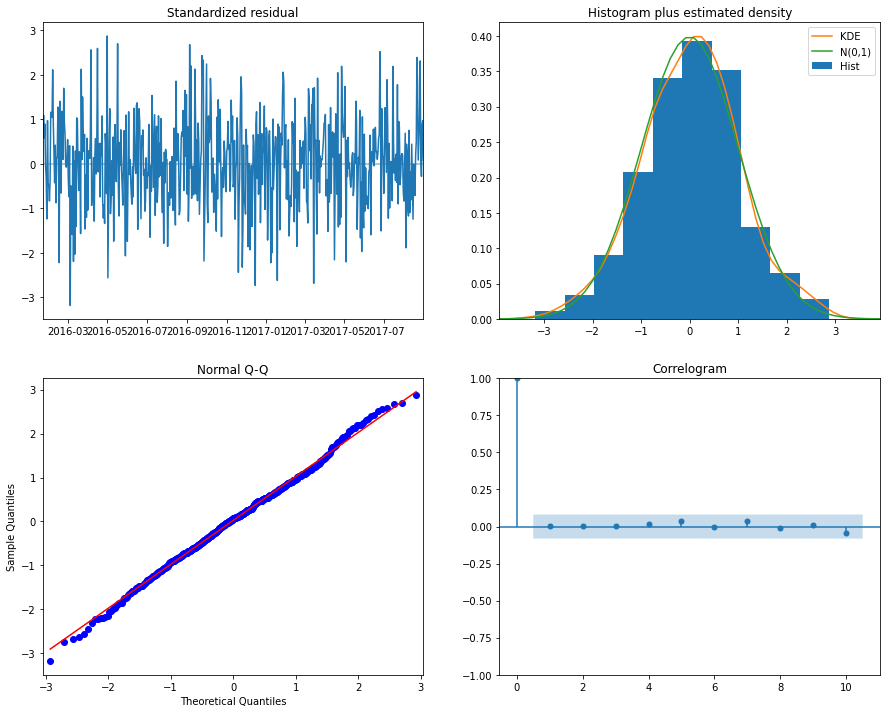

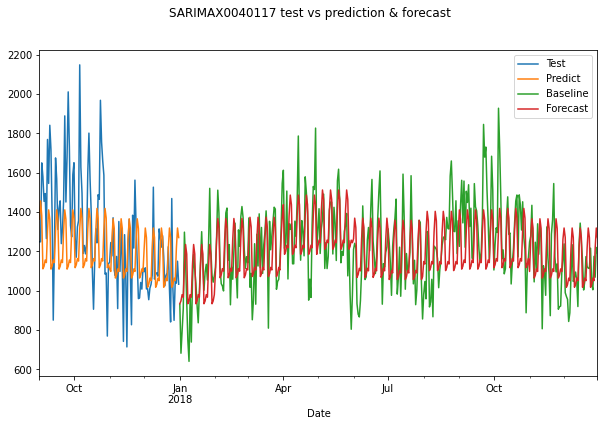

In [103]:
#most of the SARIMAX models had same MSE/MAE/ForeMSE/ForeMAE so we will pick the parameters with best AIC
SARIMAX101(0,0,4,0,1,1,7) 

Very similar results to ARIMAX

# Fourier Term features

In [139]:
# prepare Fourier terms
# once again build a df with additiona dates
Date = pd.date_range('2016-01-04', periods=1092, freq='D')
daily_list = list(df2.Daily)
for i in range(len(Date)-len(daily_list)):
    daily_list.append(1)
buf = {'Daily':daily_list}
buf = pd.DataFrame.from_dict(buf)
buf = buf.set_index(Date)
exog = buf.copy()
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 364)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 364)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 364)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 364)
exog = exog.drop(columns=['Daily'])
exog_to_train = exog.iloc[:(len(df2)-122)]
exog_to_test = exog.iloc[len(exog_to_train):]

In [169]:
# auto_arima with m=7
AA_m7_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
# Forecast
forecast = auto_arima_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]             

C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\tc18f\anaconda3\envs\learn-

In [170]:
#create a dataframe to store as csv
AA_m7_score_df = pd.DataFrame({
    'model':'AA_FT',
    'MSE': mean_squared_error(test,pred),
    'MAE': mean_absolute_error(test,pred),
    'ForeMSE':mean_squared_error(baseline,fore),
    'ForeMAE':mean_absolute_error(baseline,fore)},
index=[0])
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
AA_m7_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_m7_score.csv',
                       index=False)

In [171]:
AA_m7_score_df

model           MSE         MAE       ForeMSE     ForeMAE
0  AA_FT  75344.193806  197.463818  36121.580305  148.126185

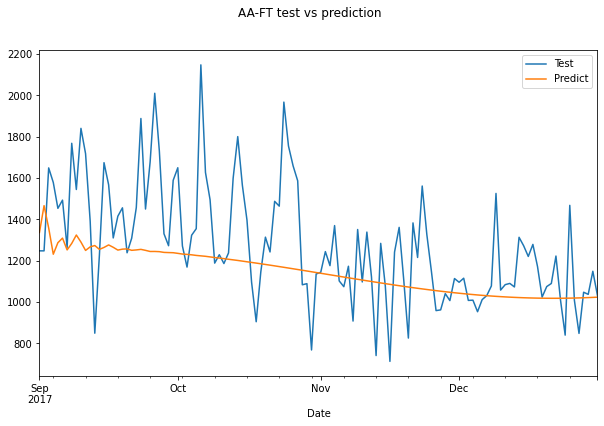

In [172]:
#view the plot of test vs pred
pd.DataFrame({'test':test,'pred':pred}).plot(figsize=(10, 6))
plt.suptitle('AA-FT test vs prediction')
plt.legend(["Test", "Predict"])
plt.savefig('AA_FT_test_pred.png')

It fails to capture the weekly periodicity

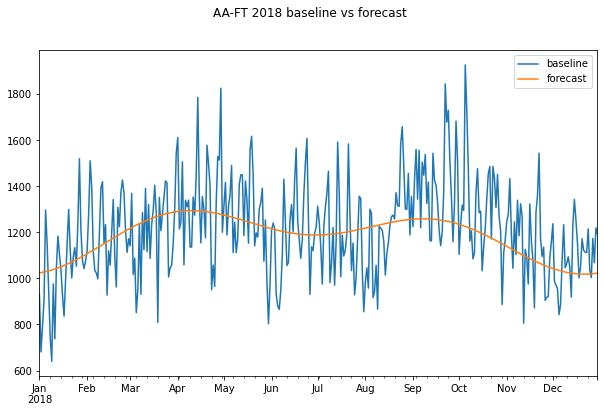

In [173]:
#view the plot of baseline vs forecast for 2018
pd.DataFrame({'baseline':baseline,'forecast':fore}).plot(figsize=(10, 6))
plt.suptitle('AA-FT 2018 baseline vs forecast')
plt.legend(["baseline", "forecast"])
plt.savefig('AA_FT_base_fore.png')

The yearly seasonality looks okay

In [181]:
# auto arima with fourier term exog and seasonality to be false, set max_p to be 7 to capture the weekly periodicty
AA_m1_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=False,
                        max_p=7, max_q=7, max_order=10, maxiter=512)
# Forecast
forecast = auto_arima_model.predict(n_periods=486, exogenous=exog_to_test)
pred = forecast[:122]
fore = forecast[122:]    

In [182]:
#create a dataframe to store as csv
AA_m1_score_df = pd.DataFrame({
    'model':'AA_FT',
    'MSE': mean_squared_error(test,pred),
    'MAE': mean_absolute_error(test,pred),
    'ForeMSE':mean_squared_error(baseline,fore),
    'ForeMAE':mean_absolute_error(baseline,fore)},
index=[0])
#save the dataframe to csv so we can load it next time instead of grid search everytime we restart
AA_m1_score_df.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_m1_score.csv',
                       index=False)

In [183]:
AA_m1_score_df

model           MSE         MAE       ForeMSE     ForeMAE
0  AA_FT  75344.193806  197.463818  36121.580305  148.126185

In [184]:
AA_m7_score_df

model           MSE         MAE       ForeMSE     ForeMAE
0  AA_FT  75344.193806  197.463818  36121.580305  148.126185

In [185]:
AA_gridsearch = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\AA_FT_gridsearch.csv')
AA_gridsearch.describe()

p          q           MSE         MAE       ForeMSE  \
count  25.000000  25.000000     25.000000   25.000000     25.000000   
mean    3.000000   3.000000  75344.193806  197.463818  36121.580305   
std     1.443376   1.443376      0.000000    0.000000      0.000000   
min     1.000000   1.000000  75344.193806  197.463818  36121.580305   
25%     2.000000   2.000000  75344.193806  197.463818  36121.580305   
50%     3.000000   3.000000  75344.193806  197.463818  36121.580305   
75%     4.000000   4.000000  75344.193806  197.463818  36121.580305   
max     5.000000   5.000000  75344.193806  197.463818  36121.580305   

          ForeMAE  
count   25.000000  
mean   148.126185  
std      0.000000  
min    148.126185  
25%    148.126185  
50%    148.126185  
75%    148.126185  
max    148.126185

It appears that the exog in the fourier term will cause the model to ignore any p,q,P,Q,m values.

In [165]:
# ARIMAX SARIMAX TBATS were the only models that captured the weekly periodicity and yearly seasonality
# let's get the scores of these models into a dataframe
tbats_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\TBATS.csv')
arimax_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\arimax_gridsearch.csv')
sarimax_df = pd.read_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Two\\data\\processed\\sarimax_gridsearch.csv')
model_score_dfs = pd.concat([tbats_df, arimax_df, sarimax_df], ignore_index=True)
model_score_dfs.head()

model           MSE         MAE           AIC       ForeMSE     ForeMAE  \
0   TBATS  79309.451551  234.278159  10264.989854  36964.783072  155.653408   
1  ARIMAX  66016.766390  192.521422   8166.199880  22544.877840  116.979432   
2  ARIMAX  66075.969724  192.693170   8076.978941  22550.514650  116.997730   
3  ARIMAX  66124.752279  192.835932   8055.094891  22549.691078  117.002240   
4  ARIMAX  66237.228099  192.996253   8034.065695  22721.094813  117.203264   

     p    d    q   P   D   Q  
0  NaN  NaN  NaN NaN NaN NaN  
1  0.0  0.0  0.0 NaN NaN NaN  
2  0.0  0.0  1.0 NaN NaN NaN  
3  0.0  0.0  2.0 NaN NaN NaN  
4  0.0  0.0  3.0 NaN NaN NaN

In [168]:
# let's view the top 3 of each scoring category
display(model_score_dfs.sort_values('MSE').head(3))
display(model_score_dfs.sort_values('ForeMSE').head(3))
display(model_score_dfs.sort_values('MAE').head(3))
display(model_score_dfs.sort_values('ForeMAE').head(3))
display(model_score_dfs.sort_values('AIC').head(3))

model           MSE         MAE          AIC       ForeMSE     ForeMAE  \
84   ARIMAX  65873.074606  193.495806  8029.195843  22576.327364  116.106628   
100  ARIMAX  65981.493356  193.961844  8020.130097  22725.925348  116.402870   
83   ARIMAX  65981.923235  192.744925  8030.793798  22531.454958  116.919819   

       p    d    q   P   D   Q  
84   5.0  0.0  3.0 NaN NaN NaN  
100  6.0  0.0  3.0 NaN NaN NaN  
83   5.0  0.0  2.0 NaN NaN NaN

model           MSE         MAE          AIC       ForeMSE     ForeMAE  \
83  ARIMAX  65981.923235  192.744925  8030.793798  22531.454958  116.919819   
52  ARIMAX  67385.958588  195.072834  8033.080664  22534.574832  116.981630   
87  ARIMAX  67383.241912  195.066074  8002.977375  22539.110393  116.978753   

      p    d    q   P   D   Q  
83  5.0  0.0  2.0 NaN NaN NaN  
52  3.0  0.0  3.0 NaN NaN NaN  
87  5.0  0.0  6.0 NaN NaN NaN

model           MSE         MAE          AIC       ForeMSE     ForeMAE  \
1   ARIMAX  66016.766390  192.521422  8166.199880  22544.877840  116.979432   
2   ARIMAX  66075.969724  192.693170  8076.978941  22550.514650  116.997730   
83  ARIMAX  65981.923235  192.744925  8030.793798  22531.454958  116.919819   

      p    d    q   P   D   Q  
1   0.0  0.0  0.0 NaN NaN NaN  
2   0.0  0.0  1.0 NaN NaN NaN  
83  5.0  0.0  2.0 NaN NaN NaN

model           MSE         MAE          AIC       ForeMSE     ForeMAE  \
84   ARIMAX  65873.074606  193.495806  8029.195843  22576.327364  116.106628   
85   ARIMAX  70054.189393  200.955517  8026.350145  22640.711729  116.219088   
100  ARIMAX  65981.493356  193.961844  8020.130097  22725.925348  116.402870   

       p    d    q   P   D   Q  
84   5.0  0.0  3.0 NaN NaN NaN  
85   5.0  0.0  4.0 NaN NaN NaN  
100  6.0  0.0  3.0 NaN NaN NaN

model           MSE         MAE          AIC       ForeMSE     ForeMAE  \
164  SARIMAX  87532.518607  238.174542  7872.071180  53177.444506  189.215869   
168  SARIMAX  87532.518607  238.174542  7876.046133  53177.444506  189.215869   
376  SARIMAX  87532.518607  238.174542  7876.067544  53177.444506  189.215869   

       p    d    q    P    D    Q  
164  0.0  0.0  4.0  0.0  1.0  1.0  
168  0.0  0.0  4.0  1.0  1.0  1.0  
376  5.0  0.0  0.0  1.0  1.0  1.0

It appears that ARIMAX with day of week and month as exog features is the best model for data with weekly AND yearly seasonality. I'd pick paramteter order=(5,0,3) since it's best score for MSE and AND ForeMAE.